In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=0a578119cc53d61c969ef9c3221d44ace1f99ceed8089a651c72dd95e2ce5bba
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [3]:
from fastai.vision import *
import fastai
import cv2
import scipy as sp
from sklearn import metrics
import os
from fastai.callbacks import *

from efficientnet_pytorch import EfficientNet


print(torch.__version__)
print(fastai.__version__)

1.7.0+cu101
1.0.61


In [4]:
!pip install -q kaggle
from google.colab import files

files.upload()

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daewogibran","key":"ee2e04eb2600742e1b4649164b6ca3da"}'}

In [9]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=5dcdd778f9014e4051119410b229c467804fdcd34de8cdce11b886585fe4e4be
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [6]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
 !chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [03:48<00:00, 41.5MB/s]
100% 9.51G/9.51G [03:48<00:00, 44.6MB/s]


In [11]:
!unzip aptos2019-blindness-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

In [14]:
path = Path("/content/style")

In [12]:
# for Kaggle
# copy pretrained weights to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
model_path = '/tmp/.cache/torch/checkpoints/efficientNet.pth'

!cp ../input/efficientnet*/efficientNet_*.pth {model_path}

cp: cannot stat '../input/efficientnet*/efficientNet_*.pth': No such file or directory


In [13]:
model_path = '/home/filip/.cache/torch/checkpoints'


In [15]:
df_train = pd.read_csv(path/'df_train_all.csv')
df_train['multiclass'] = df_train.multiclass.fillna('')
#df_train['is_valid'] = df_train['path']=='train_images'
df_train.head()

FileNotFoundError: ignored

In [ ]:
#data cleaning - see https://www.kaggle.com/h4211819/more-information-about-duplicate
#remove identical images with different classes
dups=pd.read_csv(path/'dups.csv')
df_train=df_train[~df_train.id_code.isin(dups.id_code)]


   

In [ ]:
df_train

Unnamed: 0       id_code  diagnosis                   path extension  \
0               0  000c1434d8d7          2           train_images      .png   
1               1  001639a390f0          4           train_images      .png   
2               2  0024cdab0c1e          1           train_images      .png   
3               3  002c21358ce6          0           train_images      .png   
4               4  005b95c28852          0           train_images      .png   
...           ...           ...        ...                    ...       ...   
40499       40499   44347_right          0  train_data_other_comp     .jpeg   
40500       40500    44348_left          0  train_data_other_comp     .jpeg   
40501       40501   44348_right          0  train_data_other_comp     .jpeg   
40502       40502    44349_left          0  train_data_other_comp     .jpeg   
40503       40503   44349_right          1  train_data_other_comp     .jpeg   

      multiclass               filename  
0            1 2     0-000c1434d8d7.jpg  
1        1 2 3 4     1-001639a390f0.jpg  
2              1     2-0024cdab0c1e.jpg  
3                    3-002c21358ce6.jpg  
4                    4-005b95c28852.jpg  
...          ...                    ...  
40499             40499-44347_right.jpg  
40500              40500-44348_left.jpg  
40501             40501-44348_right.jpg  
40502              40502-44349_left.jpg  
40503          1  40503-44349_right.jpg  

[40442 rows x 7 columns]

In [ ]:
df_train['is_valid']=False
train_count=(df_train.id_code[df_train.path=="train_images"]).count()
d=list(range(train_count))  # first 3600 images are the original training set
random.seed(666)
random.shuffle(d)
val_data = d[:int((len(d)+1)*.20)] #for validation set
#df_train['is_valid'][val_data]=True
df_train.is_valid.iloc[val_data]=True

/home/filip/miniconda3/envs/fastai59/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
df_train

Unnamed: 0       id_code  diagnosis                   path extension  \
0               0  000c1434d8d7          2           train_images      .png   
1               1  001639a390f0          4           train_images      .png   
2               2  0024cdab0c1e          1           train_images      .png   
3               3  002c21358ce6          0           train_images      .png   
4               4  005b95c28852          0           train_images      .png   
...           ...           ...        ...                    ...       ...   
40499       40499   44347_right          0  train_data_other_comp     .jpeg   
40500       40500    44348_left          0  train_data_other_comp     .jpeg   
40501       40501   44348_right          0  train_data_other_comp     .jpeg   
40502       40502    44349_left          0  train_data_other_comp     .jpeg   
40503       40503   44349_right          1  train_data_other_comp     .jpeg   

      multiclass               filename  is_valid  
0            1 2     0-000c1434d8d7.jpg     False  
1        1 2 3 4     1-001639a390f0.jpg      True  
2              1     2-0024cdab0c1e.jpg     False  
3                    3-002c21358ce6.jpg     False  
4                    4-005b95c28852.jpg     False  
...          ...                    ...       ...  
40499             40499-44347_right.jpg     False  
40500              40500-44348_left.jpg     False  
40501             40501-44348_right.jpg     False  
40502              40502-44349_left.jpg     False  
40503          1  40503-44349_right.jpg     False  

[40442 rows x 8 columns]

## Image Preprocessing 



In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [ ]:
def clahe(img):
    
    clahe = cv2.createCLAHE(clipLimit=2 , tileGridSize=(8,8))
    img_new_1 = clahe.apply(img[:,:,0])
    img_new_2 = clahe.apply(img[:,:,1])
    img_new_3 = clahe.apply(img[:,:,2])
    img_merge = cv2.merge([img_new_1,img_new_2,img_new_3])
    
    return img_merge

def clahel(img):
    
    image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2 , tileGridSize=(8,8))
    img_new_1 = clahe.apply(image[:,:,0])
    img_merge = cv2.merge([img_new_1,image[:,:,1],image[:,:,2]])
    
    return cv2.cvtColor(img_merge,cv2.COLOR_LAB2RGB)




In [ ]:
def get_probs(arr):
    #print(arr.shape)
    
    preds=torch.zeros([arr.size(0), arr.size(1)+1],dtype=arr.dtype)
    preds[:,4]=arr[:,3]
    preds[:,3]=(arr[:,2]-arr[:,3]).relu()
    preds[:,2]=(arr[:,1]-arr[:,2]).relu()
    preds[:,1]=(arr[:,0]-arr[:,1]).relu()
    preds[:,0]=1-arr[:,0]

    return preds

In [ ]:
def get_preds(arr):

    return get_probs(arr).argmax(1)



In [ ]:
def get_prob(arr):
    #print(arr.shape)
    
    preds=torch.zeros(arr.size(0)+1,dtype=arr.dtype)
    preds[4]=arr[3]
    preds[3]=(arr[2]-arr[3]).relu()
    preds[2]=(arr[1]-arr[2]).relu()
    preds[1]=(arr[0]-arr[1]).relu()
    preds[0]=1-arr[0]

    return preds

In [ ]:
def get_pred(arr):
    

    return get_prod(arr).argmax(0)



In [ ]:
class ConfusionMatrix(Callback):
    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        preds = get_preds((torch.sigmoid(last_output)))
        
        targs = get_preds(last_target)

        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm
        

@dataclass
class KappaScore(ConfusionMatrix):
    "Compute the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)

In [ ]:
bs = 8
num_workers = 5
np.random.seed(42)

In [ ]:
#tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=45, max_zoom=1.1, max_warp=0.0, max_lighting=0.2)

In [ ]:
#will use only the non zero diagnosis for old data
cond=(df_train['path']=='train_images')|(df_train['diagnosis']>0)
sum(cond)

13918

In [ ]:
def learn_setup(df_train,path,folder,tfms,bs,model_name,find_lr=True):
    src = (ImageList.from_df(df=df_train, 
                          path=path,
                          cols='filename',
                          folder=folder
                           )
          .split_from_df('is_valid')
          .label_from_df(cols='multiclass',label_delim=' ',label_cls=MultiCategoryList))
    
    np.random.seed(666)
    
    data = (src.transform(tfms, size=512).databunch(bs=bs,num_workers=5).normalize(imagenet_stats))
    
    data.show_batch(rows=3, figsize=(12,9))
    
    acc_02 = partial(accuracy_thresh, thresh=0.2)
    f_score = partial(fbeta, thresh=0.2)
    kappa=KappaScore(weights="quadratic")
    
    if(model_name == "resnet34"):
        learn = cnn_learner(data, models.resnet34, metrics=[kappa,acc_02,f_score])
    elif(model_name == "efficientnet-b6" ):
        model = EfficientNet.from_pretrained(model_name,num_classes=4)
        learn = Learner(data, model, metrics=[kappa,acc_02, f_score])
        #define the layers for freeze/unfreeze (just output layer and everything else)
        learn.split( lambda m: (model._conv_head,) )
        learn.freeze()
     
    learn.to_fp16()
    
    if(find_lr):
        learn.lr_find()
        learn.recorder.plot()
    return learn

In [ ]:
def predict(learn,probs_acc):
    preds, tgts = learn.get_preds(ds_type=DatasetType.Valid)
    probs=get_probs(preds)
    tgts2=tgts.long().sum(dim=1)
    preds2=probs.argmax(1)
    confusion=metrics.confusion_matrix(tgts2,preds2)
    kappa_score=metrics.cohen_kappa_score(preds2,tgts2, weights='quadratic')
    print("individual kappa=",kappa_score)
    print("individual confusion=")
    print(confusion)
    
    probs_acc=probs_acc+probs
    en_confusion=metrics.confusion_matrix(tgts2,probs_acc.argmax(1))
    en_kappa_score=metrics.cohen_kappa_score(probs_acc.argmax(1),tgts2, weights='quadratic')
    print("ensemble kappa=",en_kappa_score)
    print("ensemble confusion=")
    print(en_confusion)
    
    return probs, probs_acc

## Plain Images

In [ ]:
folder='all_train_images_512'
m1='resnet34'
m2='efficientnet-b6'
probs_acc=0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


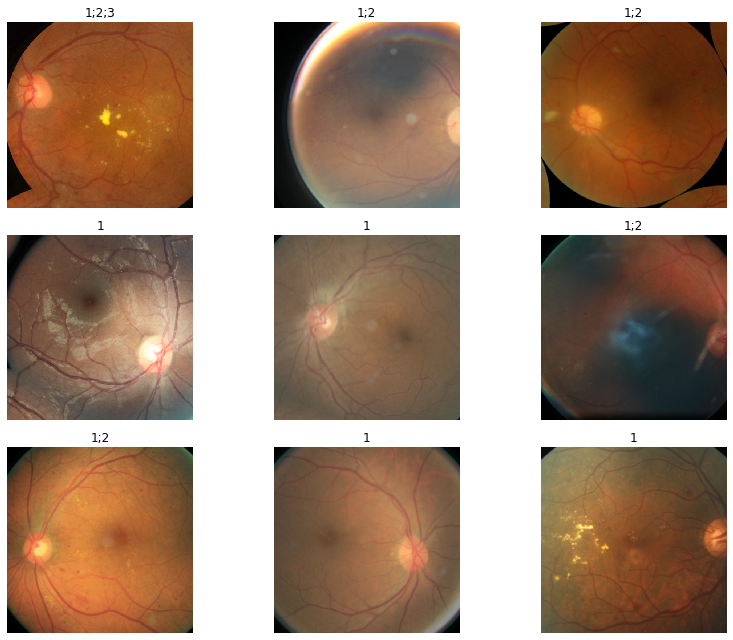

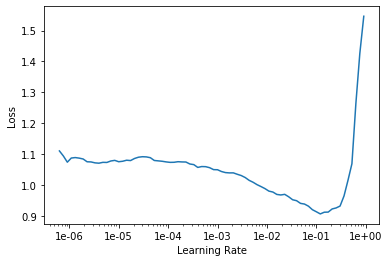

In [ ]:

learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,folder=folder,tfms=tfms,bs=32,model_name=m1)


In [ ]:
learn.fit_one_cycle(10, 1e-2)

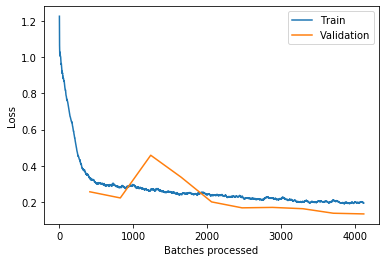

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-2))

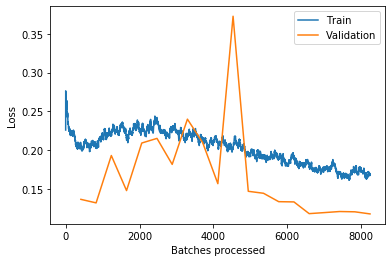

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
(probs, probs_acc)=predict(learn,probs_acc)

individual kappa= 0.9189479879547704
individual confusion=
[[367   4   2   0   0]
 [  1  30  39   0   1]
 [  0  13 165   6   3]
 [  0   0  18  12   8]
 [  0   2  11   4  34]]
ensemble kappa= 0.9189479879547704
ensemble confusion=
[[367   4   2   0   0]
 [  1  30  39   0   1]
 [  0  13 165   6   3]
 [  0   0  18  12   8]
 [  0   2  11   4  34]]


In [ ]:
#learn.save('stage-2-'+m1+'-'+folder)
#learn.export('kaggle_models/final'+m1+'-'+folder+'.pkl')

Loaded pretrained weights for efficientnet-b6


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


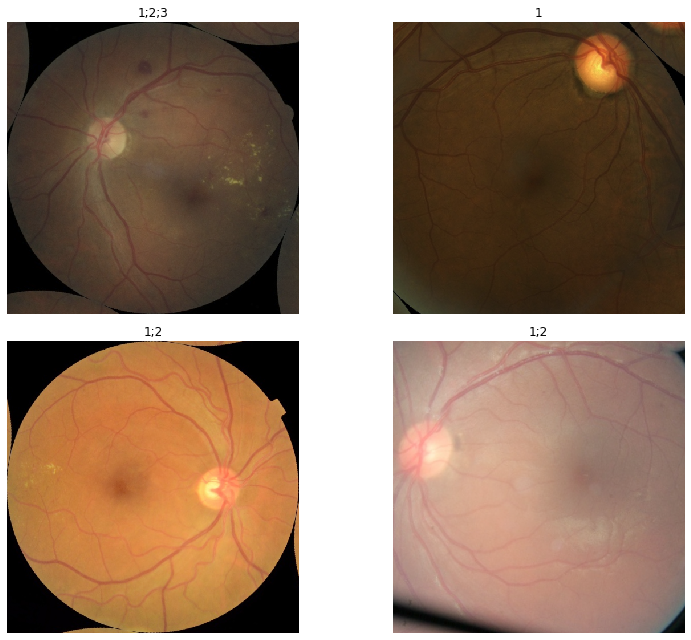

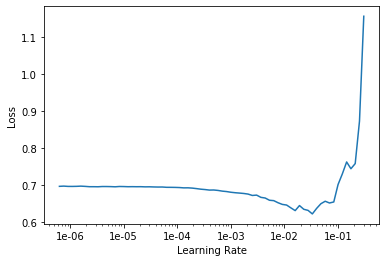

In [ ]:
#learn.destroy()
#learn=None
#gc.collect()
#torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,folder=folder,tfms=tfms,bs=4,model_name=m2)

In [ ]:
learn.fit_one_cycle(10, 1e-2)

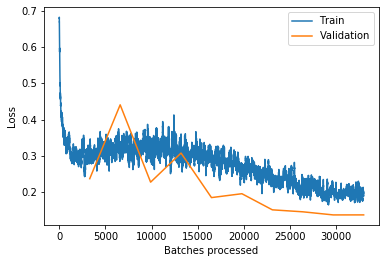

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-2))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
probs,probs_acc=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m2+'-'+folder)
#learn.export('kaggle_models/final'+m2+'-'+folder+'.pkl')

## blur=10 Images

In [ ]:
folder='all_train_images_512_blur'
m1='resnet34'
m2='efficientnet-b6'

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,folder=folder,tfms=tfms,bs=32,model_name=m1)


In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-2))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
(probs, probs_acc)=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m1+'-'+folder)
#learn.export('kaggle_models/final'+m1+'-'+folder+'.pkl')

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,
                   folder=folder,tfms=tfms,bs=4,model_name=m2)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-3))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
probs,probs_acc=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m2+'-'+folder)
#learn.export('kaggle_models/final'+m2+'-'+folder+'.pkl')

## clahe processed Images

In [ ]:
folder='all_train_images_512_clahe'
m1='resnet34'
m2='efficientnet-b5'

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,folder=folder,tfms=tfms,bs=4,model_name=m1,find_lr=False)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-3))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
probs_acc=0
learn.to_fp32()
probs,probs_acc=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m2+'-'+folder)
#learn.export('kaggle_models/final'+m2+'-'+folder+'.pkl')

## clahel processed Images

In [ ]:
folder='all_train_images_512_clahel'
m1='resnet34'
m2='efficientnet-b6'

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,folder=folder,tfms=tfms,bs=32,model_name=m1)


In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-2))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
(probs, probs_acc)=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m1+'-'+folder)
#learn.export('kaggle_models/final'+m1+'-'+folder+'.pkl')

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,
                   folder=folder,tfms=tfms,bs=4,model_name=m2)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-3))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
probs,probs_acc=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m2+'-'+folder)
#learn.export('kaggle_models/final'+m2+'-'+folder+'.pkl')

## blur=50 processed Images

In [ ]:
folder='all_train_images_512_blur_50'
m1='resnet34'
m2='efficientnet-b6'

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,folder=folder,tfms=tfms,bs=32,model_name=m1)


In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-2))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
(probs, probs_acc)=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m1+'-'+folder)
#learn.export('kaggle_models/final'+m1+'-'+folder+'.pkl')

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,
                   folder=folder,tfms=tfms,bs=4,model_name=m2)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5, 1e-3))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
probs,probs_acc=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-2-'+m2+'-'+folder)
#learn.export('kaggle_models/final'+m2+'-'+folder+'.pkl')

In [ ]:
#export to kaggle
#os.mkdir(path/'kaggle_models')
#os.system("kaggle datasets init -p '/media/SSD/APTOS 2019 Blindness/kaggle_models'")
#os.system("kaggle datasets create -p '/media/SSD/APTOS 2019 Blindness/kaggle_models'")
os.system("kaggle datasets version -p '/media/SSD/APTOS 2019 Blindness/kaggle_models' -m "+"'added a model'")

## more fitting on clahe processed Images

In [ ]:
folder='all_train_images_512_clahe'
m1='resnet34'
m2='efficientnet-b6'

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,folder=folder,tfms=tfms,bs=32,model_name=m1,find_lr=False)


In [ ]:
learn.load('stage-2-'+m1+'-'+folder);

In [ ]:
learn.to_fp32();


In [ ]:
learn.unfreeze()
learn.fit(4, slice(1e-6, 1e-3))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.to_fp32()
(probs, probs_acc)=predict(learn,probs_acc)

In [ ]:
#learn.save('stage-3-'+m1+'-'+folder)
#learn.export('kaggle_models/final'+m1+'-'+folder+'.pkl')

In [ ]:
learn.destroy()
learn=None
gc.collect()
torch.cuda.empty_cache()
learn= learn_setup(df_train=df_train[cond],path=path,
                   folder=folder,tfms=tfms,bs=4,model_name=m2)